In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, preprocessing, model_selection
import scipy
import xgboost
import shap

In [2]:
synth_table = pd.read_csv('synth_table_spherefit_11_21_24.csv')

In [3]:
synth_table = synth_table.dropna()

Text(0, 0.5, 'PDI')

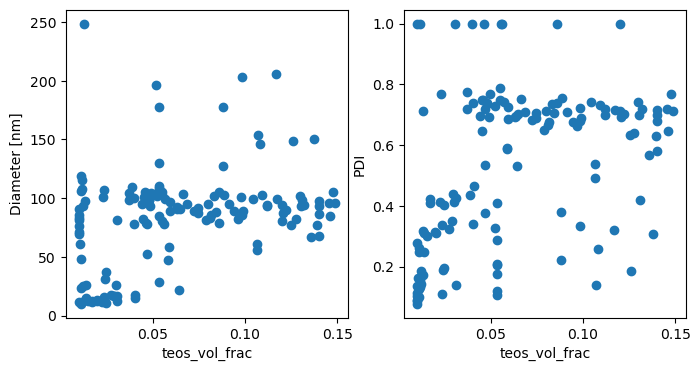

In [4]:
x = 'teos_vol_frac'
fix, ax = plt.subplots(1,2, figsize = (8, 4))

ax[0].scatter(synth_table[x], synth_table['diameter'])
ax[0].set_xlabel(x)
ax[0].set_ylabel('Diameter [nm]')

ax[1].scatter(synth_table[x], synth_table['pdi'])
ax[1].set_xlabel(x)
ax[1].set_ylabel('PDI')

Text(0, 0.5, 'PDI')

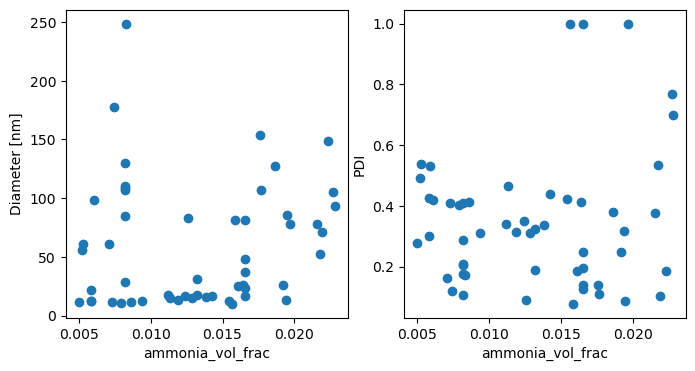

In [5]:
x = 'ammonia_vol_frac'
fix, ax = plt.subplots(1,2, figsize = (8, 4))

synth_table = synth_table[synth_table[x] < 0.023]

ax[0].scatter(synth_table[x], synth_table['diameter'])
ax[0].set_xlabel(x)
ax[0].set_ylabel('Diameter [nm]')

ax[1].scatter(synth_table[x], synth_table['pdi'])
ax[1].set_xlabel(x)
ax[1].set_ylabel('PDI')

Text(0, 0.5, 'PDI')

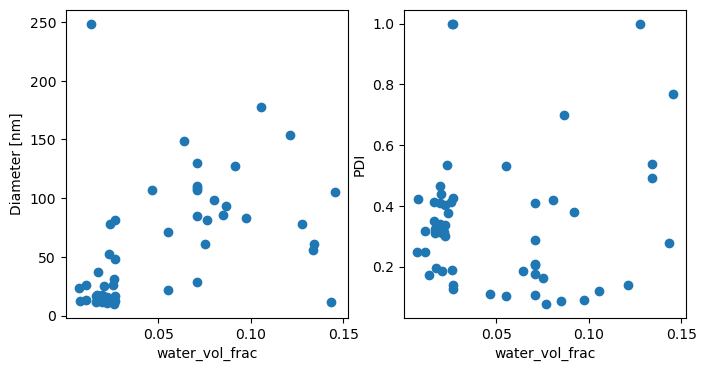

In [6]:
x = 'water_vol_frac'
fix, ax = plt.subplots(1,2, figsize = (8, 4))

ax[0].scatter(synth_table[x], synth_table['diameter'])
ax[0].set_xlabel(x)
ax[0].set_ylabel('Diameter [nm]')

ax[1].scatter(synth_table[x], synth_table['pdi'])
ax[1].set_xlabel(x)
ax[1].set_ylabel('PDI')

In [7]:
d_test

NameError: name 'd_test' is not defined

In [ ]:
scipy.stats.pearsonr(synth_table['teos_vol_frac'].to_numpy(), synth_table['diameter'].to_numpy())

In [8]:
scipy.stats.pearsonr(synth_table['teos_vol_frac'].to_numpy(), synth_table['pdi'].to_numpy())

PearsonRResult(statistic=0.29901086516246184, pvalue=0.029633707801474705)

In [9]:
scipy.stats.pearsonr(synth_table['ammonia_vol_frac'].to_numpy(), synth_table['diameter'].to_numpy())

PearsonRResult(statistic=0.096677112939251, pvalue=0.49104166527496157)

In [10]:
scipy.stats.pearsonr(synth_table['ammonia_vol_frac'].to_numpy(), synth_table['pdi'].to_numpy())

PearsonRResult(statistic=0.12853690951893063, pvalue=0.3590052950264299)

In [11]:
scipy.stats.pearsonr(synth_table['water_vol_frac'].to_numpy(), synth_table['diameter'].to_numpy())

PearsonRResult(statistic=0.46627263290851906, pvalue=0.0004332582154112697)

In [12]:
scipy.stats.pearsonr(synth_table['water_vol_frac'].to_numpy(), synth_table['pdi'].to_numpy())

PearsonRResult(statistic=0.0904504748480021, pvalue=0.5195041775661345)

## Linear model

In [13]:
## Fit a linear model
model_diameter = linear_model.LinearRegression()
model_pdi = linear_model.LinearRegression()

In [14]:
x = synth_table[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']].to_numpy()
diameter = synth_table['diameter'].to_numpy()
pdi = synth_table['pdi'].to_numpy()

In [15]:
model_diameter.fit(x, diameter)

LinearRegression()

In [16]:
diameter_fit = model_diameter.predict(x)

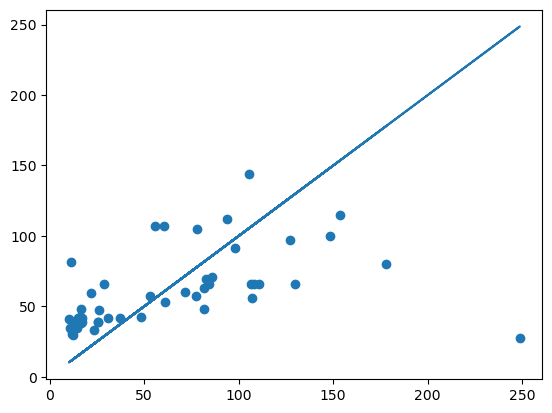

In [17]:
plt.scatter(diameter, diameter_fit)
plt.plot(diameter, diameter)

In [18]:
model_pdi.fit(x, pdi)
pdi_fit = model_pdi.predict(x)

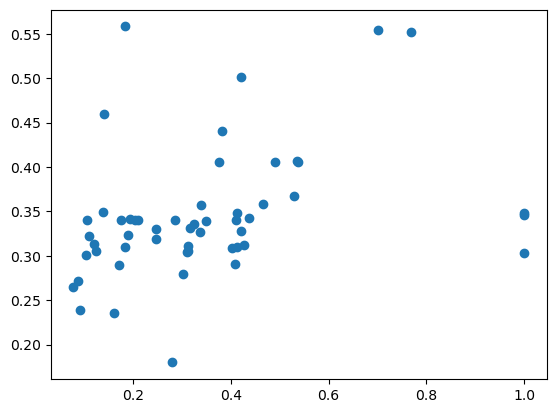

In [19]:
plt.scatter(pdi, pdi_fit)

## Do SHAP

In [103]:
scaler_x = preprocessing.MinMaxScaler()
scaler_d = preprocessing.MinMaxScaler()
scaler_pdi = preprocessing.MinMaxScaler()

In [110]:
x_scaled_full = scaler_x.fit_transform(x)
diam_scaled = scaler_d.fit_transform(diameter.reshape(-1,1))
pdi_scaled = scaler_pdi.fit_transform(pdi.reshape(-1,1))

In [105]:
regressor_d = xgboost.XGBRegressor()

In [111]:
regressor_d.fit(x_scaled_full, diam_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [112]:
x_scaled = pd.DataFrame(x_scaled_full, columns = ['TEOS vol. frac.', 'Ammonia vol. frac.', 'Water vol. frac.'])

  0%|          | 0/53 [00:00<?, ?it/s]

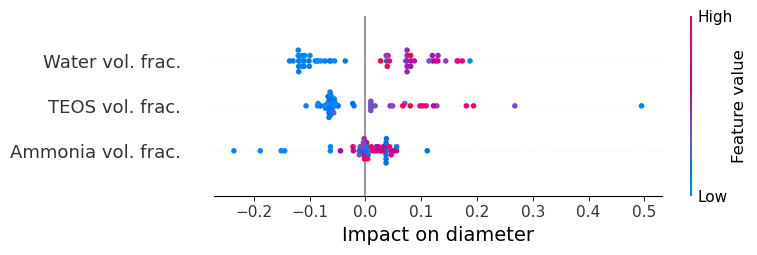

In [121]:
plt.rcParams.update({'font.size': 12})

# shap_values = shap.TreeExplainer(model).shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
fig, ax = plt.gcf(), plt.gca()
explainer = shap.KernelExplainer(regressor_d.predict, x_scaled)
shap_values = explainer.shap_values(x_scaled)
shap.summary_plot(shap_values, x_scaled, show=False)
ax.set_xlabel("Impact on diameter", fontsize=14)
plt.savefig('shap_diam.png', dpi = 300)
plt.show()



Text(0.5, 24.722222222222214, 'SHAP value')

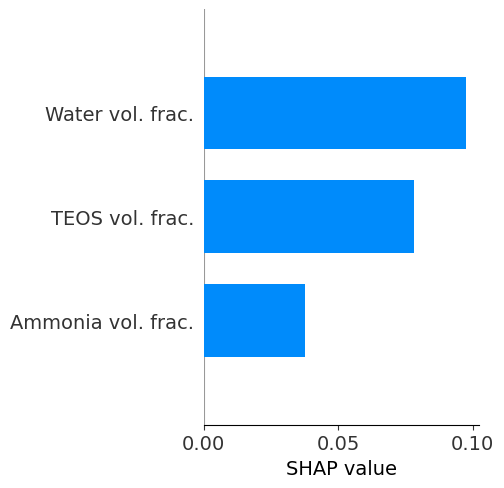

In [114]:
shap.summary_plot(shap_values, x_scaled, plot_type="bar", show=False, plot_size=[5,5])
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value", fontsize=14)

In [115]:
regressor_pdi = xgboost.XGBRegressor()
regressor_pdi.fit(x_scaled_full, pdi_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [117]:
x_scaled = pd.DataFrame(x_scaled_full, columns = ['TEOS vol. frac.', 'Ammonia vol. frac.', 'Water vol. frac.'])

  0%|          | 0/53 [00:00<?, ?it/s]

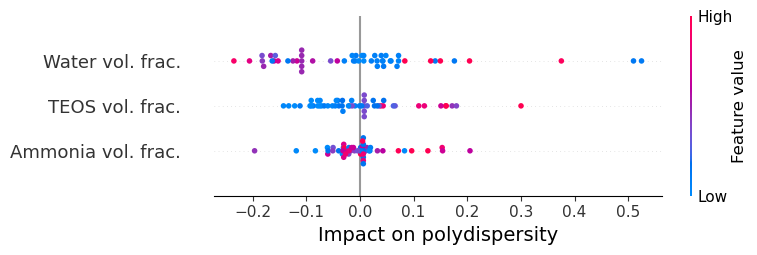

In [120]:
plt.rcParams.update({'font.size': 12})

# shap_values = shap.TreeExplainer(model).shap_values(X_test)
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)
fig, ax = plt.gcf(), plt.gca()
explainer = shap.KernelExplainer(regressor_pdi.predict, x_scaled)
shap_values = explainer.shap_values(x_scaled)
shap.summary_plot(shap_values, x_scaled, show=False)
ax.set_xlabel("Impact on polydispersity", fontsize=14)
plt.savefig('shap_pdi.png', dpi = 300)
plt.show()


Text(0.5, 24.722222222222214, 'SHAP value')

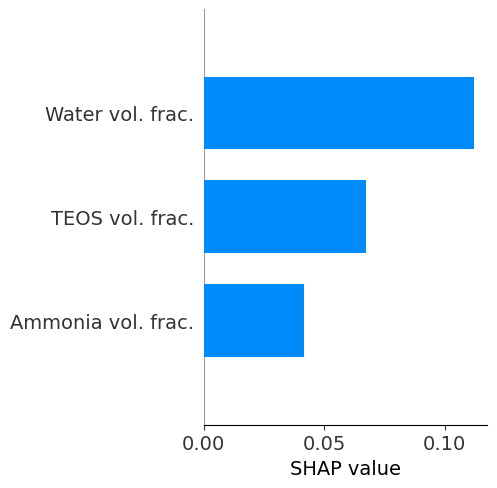

In [119]:
shap.summary_plot(shap_values, x_scaled, plot_type="bar", show=False, plot_size=[5,5])
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value", fontsize=14)